In [1]:
%%bash

pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.8 MB/s eta 0:00:00


In [2]:
import io
import os
import pathlib
import requests
import tarfile


import bs4
import hyperopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import base, feature_extraction, linear_model, metrics, model_selection, pipeline, preprocessing, tree
import shap
import xgboost as xgb


shap.initjs()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [4]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [5]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [28]:
class CustomTfidfVectorizer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, vectorizer_hyperparams):
        self.vectorizer = (
            feature_extraction.text.TfidfVectorizer(
                **vectorizer_hyperparams
            )
        )

    def fit(self, X, y=None):
        _ = self.vectorizer.fit(X)
        return self

    def transform(self, X):
        Z_csr = self.vectorizer.transform(X)
        Z_arr = Z_csr.toarray()
        Z_df = pd.DataFrame(
            Z_arr,
            columns=self.vectorizer.get_feature_names_out(),
            index=X.index
        )
        return Z_df


class CustomLabelEncoder(base.BaseEstimator, base.TransformerMixin):

    def __init__(self):
        self.encoder = preprocessing.LabelEncoder()

    def fit(self, y):
        _ = self.encoder.fit(y)
        return self

    def transform(self, y):
        z_arr = self.encoder.transform(y)
        z_s = pd.Series(
            z_arr,
            index=y.index,
            name="sentiment"
        )
        return z_s


def strip_html_tags(with_html_tags):
    soup = bs4.BeautifulSoup(with_html_tags)
    without_html_tags = soup.get_text(strip=True)
    return without_html_tags


vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.95, # ignore words that show up in more % of reviews
    "min_df": 0.05, # ignore words than show up in less % of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
    "stop_words": list(feature_extraction.text.ENGLISH_STOP_WORDS),
}

vectorizer = CustomTfidfVectorizer(
    vectorizer_hyperparams,
)

features_preprocessing = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(
        lambda s: s.apply(strip_html_tags),
    ),
    vectorizer,
)

label_encoder = CustomLabelEncoder()

target_preprocessing = pipeline.make_pipeline(
    label_encoder,
)

In [29]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = target_preprocessing.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = target_preprocessing.transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = target_preprocessing.transform(test_df.loc[:, "sentiment"])


The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


In [30]:
train_df.head()

,text,sentiment
36403,Original Movie lovers can actually love this s...,positive
22674,I didn't expect much when I saw this at the Pa...,negative
46519,"Visitors is a hard, hard movie to enjoy. It's ...",negative
22315,I love watching early colour films - you mean ...,negative
19395,I cant believe some people actually like this....,negative


In [31]:
X_train.head()

,10,absolutely,acting,action,actor,actors,actually,american,audience,away,...,world,worse,worst,worth,written,wrong,year,years,yes,young
36403,0.0,0.0,0.130205,0.000000,0.0,0.000000,0.306068,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.177952,0.000000,0.0,0.000000,0.0,0.000000,0.0
22674,0.0,0.0,0.136905,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.209248,0.0,0.000000,0.0,0.000000,0.0
46519,0.0,0.0,0.000000,0.112707,0.0,0.000000,0.098849,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
22315,0.0,0.0,0.000000,0.000000,0.0,0.139311,0.141605,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.378242,0.0
19395,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.143783,0.0,0.0,0.0,...,0.0,0.0,0.165123,0.000000,0.000000,0.0,0.173647,0.0,0.000000,0.0


In [32]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.896575
Validation accuracy: 0.8002


In [54]:
shap.TreeExplainer?

In [34]:
tree_explainer = shap.TreeExplainer(xgb_classifier)
explanation = tree_explainer(X_test)
explainer_values_df = pd.DataFrame(
    explanation.values,
    columns=X_test.columns,
    index=X_test.index
)

In [35]:
explainer_values_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 15414 to 29639
Columns: 253 entries, 10 to young
dtypes: float32(253)
memory usage: 4.9 MB


In [36]:
explainer_values_df.head()

,10,absolutely,acting,action,actor,actors,actually,american,audience,away,...,world,worse,worst,worth,written,wrong,year,years,yes,young
15414,-0.012298,-0.002959,0.042538,0.002101,0.008135,0.009485,0.007848,-0.003616,0.004059,0.002054,...,-0.036282,0.040148,-1.917040,-0.012032,-0.004474,0.009139,0.014614,-0.013492,0.008904,-0.014267
29116,-0.008139,0.000550,0.025648,-0.001328,0.006621,0.010076,0.007474,-0.001225,0.000950,0.000966,...,-0.028131,0.028561,0.113893,-0.014618,-0.000109,0.036900,-0.003661,-0.013652,0.000279,-0.008214
26450,-0.013805,0.000425,0.057068,-0.003180,0.004307,0.010046,0.008462,-0.000908,-0.005211,0.001144,...,-0.028029,0.024170,0.156224,-0.011386,-0.000089,0.012644,0.016265,-0.028288,0.000092,0.173434
36352,-0.015427,0.000654,0.043505,-0.004026,0.003372,0.017585,0.008052,-0.001198,0.001365,0.000765,...,-0.020531,0.047040,0.125676,-0.031111,0.000519,0.010560,-0.003665,0.049452,0.000146,-0.025741
22408,-0.007402,0.000254,0.028101,-0.003644,0.008295,0.017117,0.008210,0.007225,0.001042,0.000902,...,-0.038141,0.046516,0.136586,-0.014690,-0.000109,0.021383,-0.001584,-0.037087,0.003219,-0.026399


In [37]:
tree_explainer.expected_value

-0.007420707

In [38]:
explanation.base_values

array([-0.00742071, -0.00742071, -0.00742071, ..., -0.00742071,
       -0.00742071, -0.00742071], dtype=float32)

In [39]:
log_odds =(explainer_values_df.sum(axis=1)
                              .add(explanation.base_values)
                              .rename("log_odds"))
odds = np.exp(log_odds)
probs = (odds.div(1 + odds)
             .rename("probs"))
predictions = (probs.apply(lambda v: "positive" if v >= 0.5 else "negative")
                    .rename("prediction"))
sentiment = test_df.loc[:, "sentiment"]
pd.concat([log_odds, probs, predictions, sentiment], axis=1)

,log_odds,probs,prediction,sentiment
15414,-4.824167,0.007969,negative,negative
29116,2.065988,0.887553,positive,positive
26450,0.647796,0.656514,positive,positive
36352,1.392529,0.800996,positive,positive
22408,-1.410119,0.196215,negative,negative
...,...,...,...,...
41052,-1.360597,0.204143,negative,negative
13947,-0.251515,0.437451,negative,negative
1450,2.933886,0.949496,positive,positive
29808,4.102112,0.983731,positive,positive


In [40]:
test_df.head(1)

,text,sentiment
15414,This was one of the worst films I have ever se...,negative


In [43]:
X_test.head(1)

,10,absolutely,acting,action,actor,actors,actually,american,audience,away,...,world,worse,worst,worth,written,wrong,year,years,yes,young
15414,0.152761,0.197542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.173772,0.0,0.0,0.0,0.182742,0.0,0.0,0.0


In [41]:
test_df.loc[15414, "text"]

'This was one of the worst films I have ever seen.<br /><br />I usually praise any film for some aspect of its production, but the intensely irritating behaviour of more than half the characters made it hard for me to appreciate any part of this film.<br /><br />Most common was the inference that the bloke who designed the building was at fault an avalanche collapsing it. Er ok.<br /><br />Also, trying to out ski an avalanche slalom style is not gonna work. Running 10 feet into some trees is not gonna work. Alas it does here. As mentioned before the innate dumbness and sheer stupidity of some characters is ridiculous. In an enclosed space, with limited oxygen a four year old could tell you starting a fire is not a good idea.<br /><br />Anyway, about 5 minutes of the movie redeems itself and acquires some appreciation. However, if you have a modicum of intelligence you too will find most of this film hard to tolerate.<br /><br />It pains me that so many quality stories go unproduced and

In [44]:
xgb_classifier.predict(X_test.loc[[15414], :])

array([0])

In [45]:
tree_explainer.expected_value + explainer_values_df.loc[15414, :].sum()

-4.824167

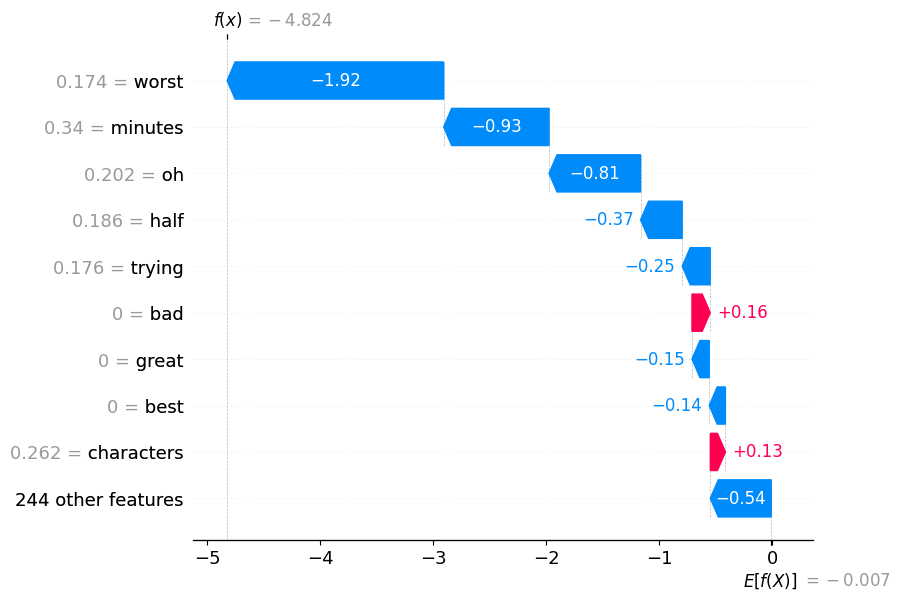

In [47]:
shap.plots.waterfall(explanation[0])

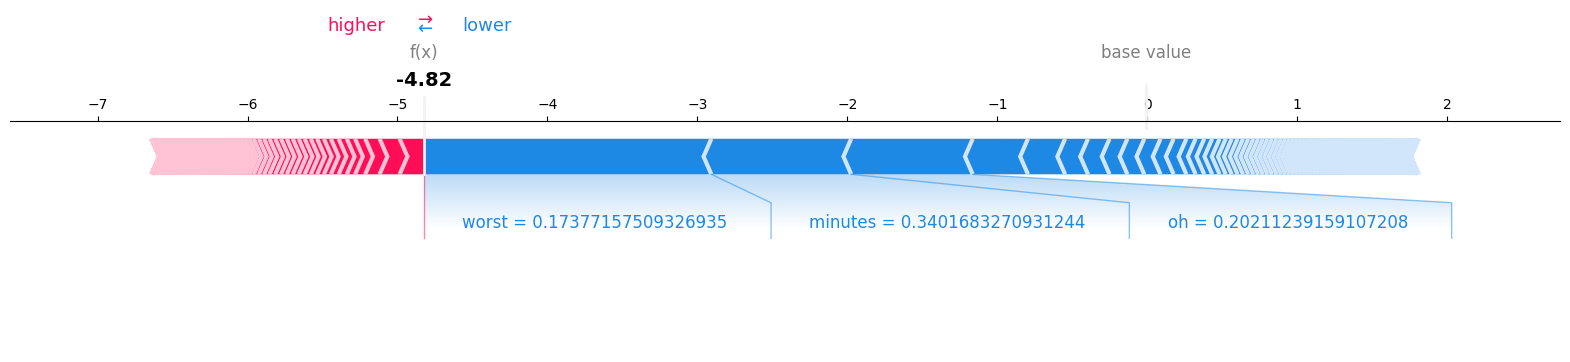

In [50]:
_ = (
    shap.plots
        .force(
            base_value=explanation.base_values,
            shap_values=explanation.values[0,:],
            features=X_test.iloc[0],
            matplotlib=True,
         )
)

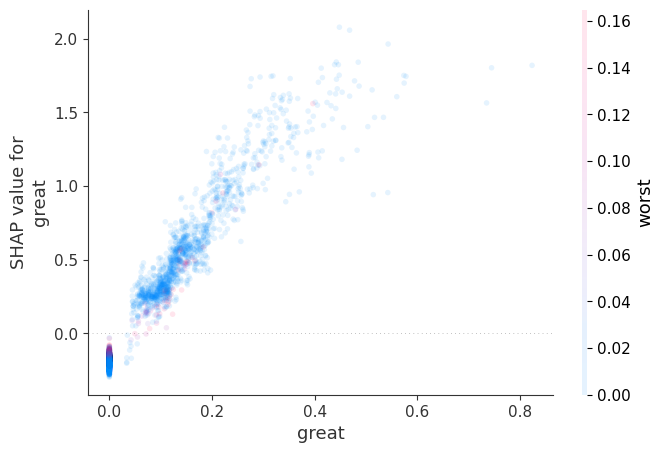

In [56]:
_ = (
    shap.plots
        .scatter(
            explanation[:, 'great'],
            color=explanation,
            x_jitter=0,
            hist=False,
            alpha=0.1
            )
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


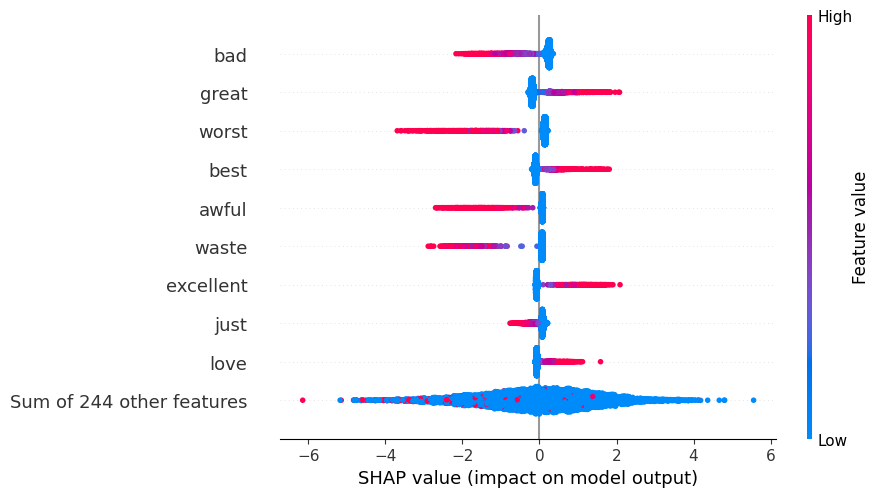

In [55]:
_ = (
    shap.plots
        .beeswarm(
            explanation,
            )
)